In [1]:
#Code: Import all the libraries
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar100
from keras import backend as K

In [2]:
#Code: Function to convert RGB images to Grayscale

def rgb_2_gray(image):
	return np.dot(image[..., :3], [0.299, 0.587, 0.114])


In [14]:
#Code: Load the dataset

(x_train, _), (x_test, _) = cifar100.load_data()


In [15]:
# input image dimensions
# we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

In [16]:
# create saved_images folder
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

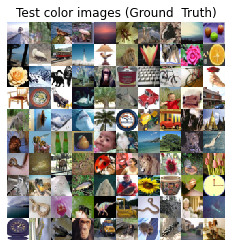

In [17]:
# display the 1st 100 input images (color and gray)
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

In [18]:
# convert color train and test images to gray
x_train_gray = rgb_2_gray(x_train)
x_test_gray = rgb_2_gray(x_test)


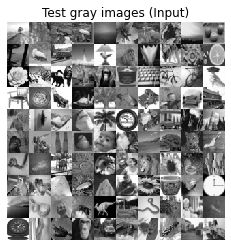

In [19]:
# display grayscale version of test images
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [20]:
#Code: Normalize the data

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train_gray = x_train_gray.astype('float32') / 255.
x_test_gray = x_test_gray.astype('float32') / 255.


In [22]:
#Code: Hyper-parameters

input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256]


In [34]:
#Code: Encoder
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
shape = K.int_shape(x)
# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1,418,496
Trainable params: 1,418,496
Non-tra

In [35]:
#Code: Decoder

latent_inputs = Input(shape =(latent_dim, ), name ='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-
# Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters = filters,
					kernel_size = kernel_size,
					strides = 2,
					activation ='relu',
					padding ='same')(x)
outputs = Conv2DTranspose(filters = channels,
						kernel_size = kernel_size,
						activation ='sigmoid',
						padding ='same',
						name ='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name ='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense_2 (Dense)             (None, 4096)              1052672   
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 8, 8, 256)        590080    
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 32, 32, 64)       7379

In [36]:
autoencoder = Model(inputs, decoder(encoder(inputs)),name ='autoencoder')
autoencoder.summary()


In [38]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# called every epoch
callbacks = [lr_reducer, checkpoint]


In [50]:
history =autoencoder.fit(x_train_gray,
				x_train,
				validation_data =(x_test_gray, x_test),
				epochs = 30,
				batch_size = batch_size,
				callbacks = callbacks)


Epoch 1/30
1562/1563 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 00001: val_loss did not improve from 0.01126
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0053 - val_loss: 0.0118 - lr: 1.0000e-05
Epoch 2/30
1561/1563 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 00002: val_loss did not improve from 0.01126
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0053 - val_loss: 0.0118 - lr: 1.0000e-05
Epoch 3/30
1560/1563 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 00003: val_loss did not improve from 0.01126
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0053 - val_loss: 0.0118 - lr: 1.0000e-05
Epoch 4/30
1562/1563 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 00004: val_loss did not improve from 0.01126
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0053 - val_loss: 0.0118 - lr: 1.0000e-05
Epoch 5/30
1559/1563 [======================

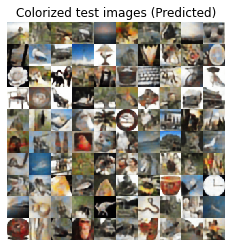

In [40]:
#Code: Results and analysis
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)

# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()